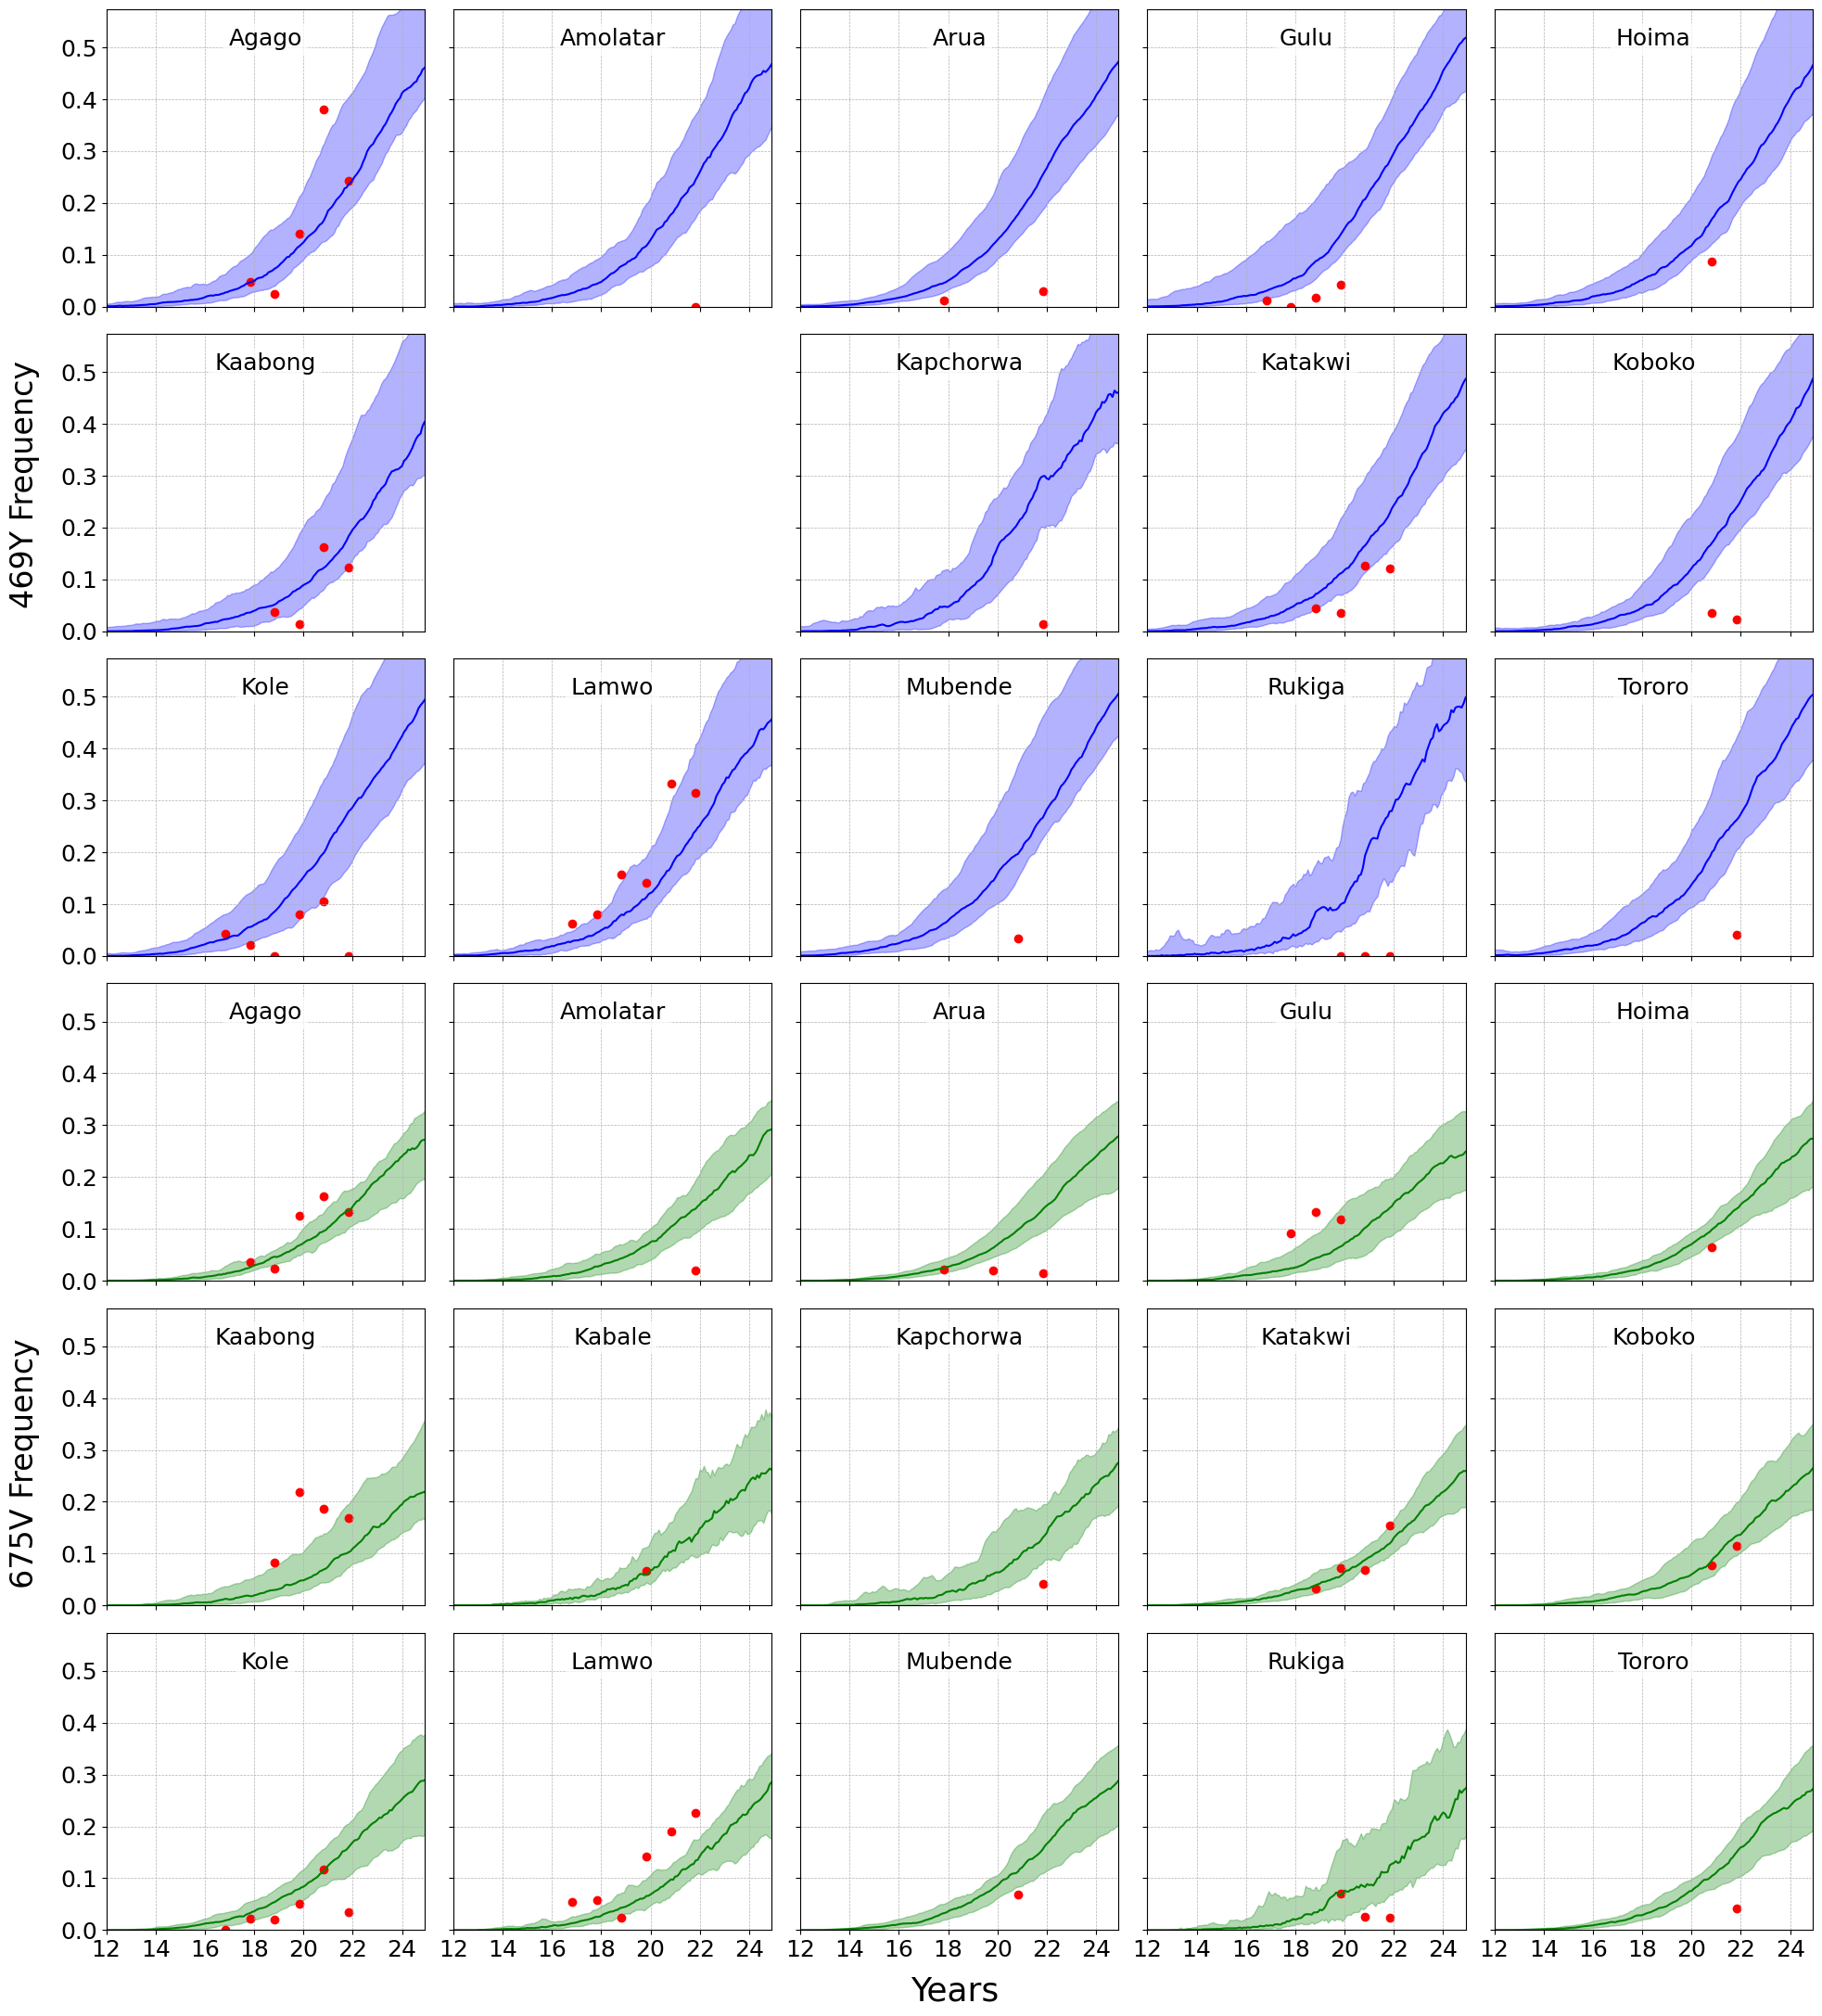

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# LOAD THE DATA
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the datasets
status_quo_k13_quantiled_df = pd.read_csv('./data/fig2_data/status_quo_k13_quantiled_0002_v2.csv')
uga_469Y_mutations_df = pd.read_csv('./data/fig2_data/uga_469Y_mutations.csv')
uga_675V_mutations_df = pd.read_csv('./data/fig2_data/uga_675V_mutations.csv')
uga_districts_df = pd.read_csv('./data/fig2_data/uga_districts.csv')

# Identify unique districts
unique_districts_469Y = set(uga_469Y_mutations_df['District'].unique())
unique_districts_675V = set(uga_675V_mutations_df['District'].unique())
combined_unique_districts = unique_districts_469Y.union(unique_districts_675V)

# Map district names to their respective IDs and filter status_quo_k13_quantiled_df
district_id_map = uga_districts_df.set_index('Label')['ID'].to_dict()

# Filter datasets based on locations specific to each mutation dataset
district_ids_469Y = [district_id_map[district] for district in unique_districts_469Y if district in district_id_map]
district_ids_469Y.append(40)
filtered_status_quo_469Y_df = status_quo_k13_quantiled_df[status_quo_k13_quantiled_df['locationid'].isin(district_ids_469Y)]

district_ids_675V = [district_id_map[district] for district in unique_districts_675V if district in district_id_map]
filtered_status_quo_675V_df = status_quo_k13_quantiled_df[status_quo_k13_quantiled_df['locationid'].isin(district_ids_675V)]


# Invert the district_id_map for easy plotting
id_to_district_map = {v: k for k, v in district_id_map.items()}

# Variables for adjustments
start_display_year = 2012
end_display_year = 2024
year_interval = 2
fontsize = 20  # Font size for the graphs

# Calculate monthlydataid corresponding to the start and end years
start_year = 2004
months_per_year = 12
start_monthly_id = (start_display_year - start_year) * months_per_year + 1
end_monthly_id = (end_display_year - start_year + 1) * months_per_year

# Create a list of years to display on the x-axis
years_to_display = list(range(start_display_year, end_display_year + 1, year_interval))
monthly_ids_to_display = [(year - start_year) * months_per_year + 1 for year in years_to_display]
year_labels = [str(year)[-2:] for year in years_to_display]

# Determine number of columns for subplots
num_columns = 5

# Determine number of rows for each plot
unique_locations_469Y = filtered_status_quo_469Y_df['locationid'].unique()
num_rows_469Y = (len(unique_locations_469Y) + num_columns - 1) // num_columns

unique_locations_675V = filtered_status_quo_675V_df['locationid'].unique()
# move 40 to the end
unique_locations_675V = list(unique_locations_675V)
# unique_locations_675V.remove(40)
# unique_locations_675V.append(40)

num_rows_675V = (len(unique_locations_675V) + num_columns - 1) // num_columns
# Compute shared y-axis limits
min_469Y = min(filtered_status_quo_469Y_df['469Y_25th_percentile'].min(), filtered_status_quo_469Y_df['469Y_75th_percentile'].min())
max_469Y = max(filtered_status_quo_469Y_df['469Y_25th_percentile'].max(), filtered_status_quo_469Y_df['469Y_75th_percentile'].max())

min_675V = min(filtered_status_quo_675V_df['675V_25th_percentile'].min(), filtered_status_quo_675V_df['675V_75th_percentile'].min())
max_675V = max(filtered_status_quo_675V_df['675V_25th_percentile'].max(), filtered_status_quo_675V_df['675V_75th_percentile'].max())


# Combined figure
fig, axes = plt.subplots(nrows=num_rows_469Y + num_rows_675V, ncols=num_columns, figsize=(20, 4 * (num_rows_469Y + num_rows_675V)), sharex='col', sharey=False)

# Plot for 469Y
for idx, location in enumerate(unique_locations_469Y):
    # last idx
    row, col = divmod(idx, num_columns)
    district_name = id_to_district_map[location]
    subset = filtered_status_quo_469Y_df[filtered_status_quo_469Y_df['locationid'] == location]
    mutation_data = uga_469Y_mutations_df[uga_469Y_mutations_df['District'] == district_name]
    
    ax = axes[row, col]
    ax.plot(subset['monthlydataid'], subset['469Y_median'], color='blue')
    ax.fill_between(subset['monthlydataid'], subset['469Y_05th_percentile'], subset['469Y_95th_percentile'], color='blue', alpha=0.3)
    
    # Place title inside the plot
    ax.text(0.5, 0.9, district_name, fontsize=fontsize-2, transform=ax.transAxes, 
            ha='center', va='center', bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))
    
    
    
    for year, frequency in zip(mutation_data['Year'], mutation_data['Frequency']):
        monthly_id_start = (year - start_year) * months_per_year + 11
        ax.scatter(monthly_id_start, frequency, color='red', marker='o')
    
    # ax.set_title(district_name, fontsize=fontsize)
    ax.set_xlim([start_monthly_id, end_monthly_id])
    ax.set_xticks(monthly_ids_to_display)
    ax.set_xticklabels(year_labels, fontsize=fontsize - 2)
    ax.set_ylim([0, max_469Y])
    ax.tick_params(axis='y', labelsize=fontsize - 2)
    # not first column
    if col != 0:
        ax.set_yticklabels([])
        
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# Plot for 675V
for idx, location in enumerate(unique_locations_675V):
    row, col = divmod(idx, num_columns)
    row += num_rows_469Y  # Offset by the number of rows for 469Y
    district_name = id_to_district_map[location]
    subset = filtered_status_quo_675V_df[filtered_status_quo_675V_df['locationid'] == location]
    mutation_data = uga_675V_mutations_df[uga_675V_mutations_df['District'] == district_name]
    
    ax = axes[row, col]
    ax.plot(subset['monthlydataid'], subset['675V_median'], color='green')
    ax.fill_between(subset['monthlydataid'], subset['675V_05th_percentile'], subset['675V_95th_percentile'], color='green', alpha=0.3)
    
    # Place title inside the plot
    ax.text(0.5, 0.9, district_name, fontsize=fontsize-2, transform=ax.transAxes, 
            ha='center', va='center', bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))
    
    for year, frequency in zip(mutation_data['Year'], mutation_data['Frequency']):
        monthly_id_start = (year - start_year) * months_per_year + 11
        ax.scatter(monthly_id_start, frequency, color='red', marker='o')
    
    # ax.set_title(district_name, fontsize=fontsize)
    ax.set_xlim([start_monthly_id, end_monthly_id])
    ax.set_xticks(monthly_ids_to_display)
    ax.set_xticklabels(year_labels, fontsize=fontsize - 2)
    
    ax.set_ylim([0, max_469Y])
    ax.tick_params(axis='y', labelsize=fontsize - 2)
    # ax.set_yticks([0.0,0.1,0.2,0.3])
    if col != 0:
        ax.set_yticklabels([])
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)



# Remove unused subplots
# for i in range(len(unique_locations_469Y) + len(unique_locations_675V), len(axes.flat)):
    # fig.delaxes(axes.flat[i])
    

# fig.delaxes(axes.flat[len(unique_locations_469Y)])

# remove ax [1,1]
fig.delaxes(axes[1,1])

# Add y-labels for each plot section
fig.text(0.02, 0.71, '469Y Frequency', va='center', rotation='vertical', fontsize=fontsize+4)
fig.text(0.02, 0.27, '675V Frequency', va='center', rotation='vertical', fontsize=fontsize+4)

fig.suptitle('Years', x=0.53, y=0.04, fontsize=fontsize + 6)


plt.tight_layout(rect=[0.04, 0.04, 1, 0.95])
plt.show()
